In [1]:
%matplotlib inline

In [2]:
from IPython.display import clear_output
from PIL import Image

import os

import pprint
import time
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def show_image(data, class_list=None):
    image, label = data
    image = image.numpy().transpose((1, 2, 0))
        
    if class_list:
        label = class_list[label]
        
    plt.title(label)
    plt.imshow(image)

In [4]:
def print_training_history(history):
    training_steps = np.array([step for step, _ in history])
    loss = np.array([loss for _, loss in history])

    fig, ax = plt.subplots()
    ax.plot(training_steps, loss)

    ax.set(xlabel='training_steps', ylabel='loss')
    ax.grid()
    plt.show()

Our breakdown of machine learning was:
- data
- model
- training.

We're going to go into more detail on these:
- data
    - dataset
    - dataloader
    - data augmentation
- model
    - neural network layer
    - activation function
- training
    - loss function
    - optimizer

We covered all of data.
We're going to go into the training function from earlier!
Afterwards, we'll talk more about activation functions, loss functions, and optimizers.

Remember our training function:

In [5]:
def train(model, criterion, opt, train_dl, test_dl, epochs=23, evaluate=True):
    
    # The history of our training, inputs step, loss pair.
    history = []
    
    # Initialize step
    step = 1

    # This is our loss function
    # criterion = torch.nn.MSELoss()
    
    # This is our optimizer
    # opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    
    # This is the code that allows us to use our GPU to train.
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # This controls how many iterations we want to make, which helps control how well our model
    # generalizes.
    for epoch in range(epochs):
        
        t = time.time()
        batch_start = t

        #This is how we get our inputs and labels from our dataloader.
        for i, (inputs, label) in enumerate(train_dl):
            
            # This sends the inputs and the labels to our device.
            inputs, label = inputs.to(device), label.to(device)

            # We have to zero out our gradients, because they can get too large.
            opt.zero_grad(set_to_none=True)
            
            # This is the prediction of our model
            #out = torch.nn.LogSoftmax(dim=1)(model(inputs))
            out = model(inputs)
            
            # Remember loss functions take two inputs, the prediction and the label.
            loss = criterion(out, label)
            
            # This step gets our gradients.
            loss.backward()
            
            # This is how we update our neural network weights. 
            opt.step()
            
            # Append current step and loss.
            history.append((step, loss.item()))
            step += 1

            # Get time Batch training is taking.
            t = time.time() - batch_start

            # Gives a nice representation of how our training is progressing.
            clear_output(wait=True)
            print("Epoch | Batch | Time(s) | Loss")
            print("------------------------------")
            print(f"{epoch + 1:5d} | {i:5d} | {int(t):7d} | {loss:.5f}")
        
        print(f"Finished epoch {epoch + 1}.")
    print(f"Finished Training!")
    if evaluate:
        print("Evaluating")
        model_evaluate(model, test_dl)
    
    return history

In [6]:
def model_evaluate(model, test_loader):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
    print(f'Accuracy of the network on 10000 test images: {100 * correct // total} %')
    return 100 * correct // total

In [7]:
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=torch.tensor([0.1307]), std=torch.tensor([0.3081]))
    ])

In [8]:
train_ds = torchvision.datasets.CIFAR10(root='../data',
                                      train=True,
                                      download=True,
                                      transform=transforms)

test_ds = torchvision.datasets.CIFAR10(root='../data',
                                     train=False,
                                     download=True,
                                     transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Change the batch size until your GPU near's capacity.
# We can check this by running `nvidia-smi` in Windows PowerShell
bs = 2048

# Think about how many training steps you want your model to take.
# Typically this is a function of dataset size, batch size, and epochs.
# The number of steps is: ((len(dataset) // batch_size) + 1) * epochs
# So, if we had 50,000 elements in our dataset, a batch size of 1024, and 23 epochs, then 
# we would take 1,127 training steps.
# In industry, the models can train for hundreds of thousands and even millions of steps.
epochs = 10

In [11]:
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=bs,
                                       shuffle=True,
                                       num_workers=4)
test_dl = torch.utils.data.DataLoader(test_ds,
                                      batch_size=bs,
                                      shuffle=False,
                                      num_workers=4)

In [96]:
# Insert your model here
# model = LeNet()
model = torchvision.models.resnet18(pretrained=True)

In [97]:
model.fc = torch.nn.Linear(model.fc.in_features, 10)

In [98]:
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [99]:
history = train(model, criterion, opt, train_dl, test_dl, epochs=500, evaluate=True)

Epoch | Batch | Time(s) | Loss
------------------------------
  500 |    24 |      11 | 0.00000
Finished epoch 500.
Finished Training!
Evaluating
Accuracy of the network on 10000 test images: 79 %


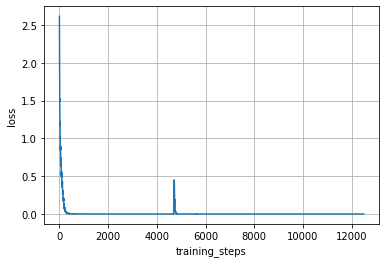

In [100]:
print_training_history(history)

In [101]:
model_evaluate(model, test_dl)

Accuracy of the network on 10000 test images: 79 %


79

Now we save our model!

In [102]:
# Naming convention
# ../models/model_name_TIME_dataset.pt

PATH = '../models/resnet50_20220720_CIFAR10.pt'

torch.save(model.state_dict(), PATH)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [18]:
PATH = '../models/resnet50_20220720_CIFAR10.pt'

We load our model in the following manner:

In [23]:
# Insantiate the correct model class
model = torchvision.models.resnet18(pretrained=False)

In [24]:
model.fc = torch.nn.Linear(model.fc.in_features, 10)

In [25]:
model.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
model_evaluate(model, test_dl)

Accuracy of the network on 10000 test images: 9 %


9

In [27]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [28]:
model_evaluate(model, test_dl)

Accuracy of the network on 10000 test images: 79 %


79

Ok, I'm going to give you a list of loss functions and a list of optimizers.
You are then going to fiddle around with the hyperparameters and see if you can get your model to train more quickly.

**Criterion**
- `torch.nn.MSELoss()`
- `torch.nn.NLLLoss()`
- `torch.nn.L1Loss()`

**Optimizers**
- `torch.optim.Adadelta(params, lr=1, rho=0.9, eps=1e-06, weight_decay=0)`
- `torch.optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0, eps=1e-10)`
- `torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)` **NOTE**: I will tell you the most commonly used value for `lr`.
- `torch.optim.AdamW(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)`
- `torch.optim.ASGD(params, lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)`
- `torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0)`
- `torch.optim.SGD(params, lr=0.001, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

We'll go through these on the board.

In [ ]:
# Add some of the transforms, that we talked about in class number 5, to the list.
# T.ToTensor and T.Normalize must remain.

transforms = torchvision.transforms.Compose(
    [T.ToTensor(),
     T.Normalize(mean=torch.tensor([0.1307]), std=torch.tensor([0.3081])),
     # Add the new transforms here.
    ])

In [ ]:
train_ds = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transforms)

test_ds = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transforms)

In [ ]:
# Set your batch size
# bs = ..

# Call your data.
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=bs,
                                       shuffle=True,
                                       num_workers=4)
test_dl = torch.utils.data.DataLoader(test_ds,
                                      batch_size=bs,
                                      shuffle=False,
                                      num_workers=4)

In [ ]:
# Instantiate your model
# model = ...

# Select your loss function
# criterion = ...

# Input the hyperparameters for your optimizer.
# Note, if you're note sure what hyperparameters to use for your optimizer, choose ones
# near the default values.
# Be sure to insert model.parameters() in the first slot!
# opt = torch.optim....

# choose your epochs and train your model!
# train(model, criterion, opt, train_dl, test_dl, epochs, evaluate=True)

We're not going to upload an image to our images folder, then open it to make a prediction.

In [ ]:
image = Image.open('./images/your_pic.jpg')

In [ ]:
def predict(model, image, class_list=None):
    
    image = T.Resize((28, 828))(image)
    image = T.ToTensor()(image)
    
    pred = model(image)
    pred = torch.argmax(pred).item()
    
    if class_list:
        pred = class_list[pred]
    
    return pred